# Assignment 1

**Due to**: 20/12/2021 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

# Intro

In this assignment  we will ask you to perform POS tagging using neural architectures

You are asked to follow these steps:
1. Download the corpora and split it in training and test sets, structuring a dataframe.
2. Embed the words using GloVe embeddings
3. Create a baseline model, using a simple neural architecture
4. Experiment doing small modifications to the baseline model, choose hyperparameters using the validation set
5. Evaluate your two best model
6. Analyze the errors of your model


In [7]:
import copy
import os
import re
import tarfile
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from urllib import request
import collections
import tensorflow as tf
import gensim
import gensim.downloader as gloader
from tensorflow import keras
from tensorflow.keras import layers

WINDOW_LENGTH = 9
EMBEDDING_SIZE = 300


In [8]:
dataset_folder = os.path.join(os.getcwd(), "Datasets")
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path_zip = os.path.join(dataset_folder, "dependency_treebank.zip")


def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")


def extract_dataset(download_path: str, extract_path: str):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")


download_dataset(dataset_path_zip, url)
extract_dataset(dataset_path_zip, dataset_folder)
dataset_path = os.path.join(dataset_folder, "dependency_treebank")


def encode_dataset(dataset_path: str, debug: bool = True) -> pd.DataFrame:
    dataframe_rows = []
    for index, file in tqdm(enumerate(sorted(os.listdir(dataset_path)))):
        file_name = os.path.join(dataset_path, file)
        with open(file_name) as f:
            lines = f.readlines()
        full_file = ''.join(lines)  # since lines is a list we use a single string called full_file
        full_file = re.sub(r'(\t\d+)', '', full_file)  # remove numbers from each lines of dataset
        full_file = re.sub(r'(\t)', ' ', full_file)  # replace \t with a space
        sentences = full_file.split('\n\n')
        for s in sentences:  #separate all words from their tags
            text = ''.join(re.findall(r'.+ ', s))
            labels = ''.join(re.findall(r' .+', s))
            labels = re.sub(r' (.+)', r'\1 ', labels)
            labels = re.sub('\n', ' ', labels)

            # split into train, val and test
            if index <= 100:
                split = 'train'
            elif 100 < index <= 150:
                split = 'val'
            else:
                split = 'test'

            # create a single row of dataframe
            dataframe_row = {
                "text": text,
                "POStagging": labels,
                "split": split,
            }
            dataframe_rows.append(dataframe_row)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text",
             "POStagging",
             "split"]]
    dataframe_path = os.path.join(dataset_folder, "dependency_treebank_df.pkl")
    df.to_pickle(dataframe_path)
    return df


df = encode_dataset(dataset_path)
df;

Extracting dataset... (it may take a while...)
Extraction completed!


199it [00:00, 977.00it/s]


In [9]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    embedding_vocabulary = set(embedding_model.index_to_key)
    oov = set(word_listing).difference(embedding_vocabulary)
    print("Total OOV terms: {0} ({1:.2f}%)".format(len(list(oov)), float(len(list(oov))) / len(word_listing)))
    return list(oov)


def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int,
                           oov_terms) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = None
        self.embedding_matrix = None
        self.vocab = None

        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')

        self.vocab = self.tokenizer.word_index

        if self.build_embedding_matrix:
            print('Loading embedding model! It may take a while...')
            self.embedding_model = gloader.load(f"glove-wiki-gigaword-{self.embedding_dimension}")

            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=list(self.vocab.keys()))

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab) + 1,
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)
            print('Done!')

    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)


tokenizer_args = {
    'oov_token': 1,  # The vocabulary id for unknown terms during text conversion
    'lower': False,
    'filters': ''
}
tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=EMBEDDING_SIZE,
                           embedding_model_type="glove")

tokenizer.build_vocab(df['text'].values)
tokenizer_info = tokenizer.get_info()

print('Tokenizer info: ', tokenizer_info)



Fitting tokenizer...
Fit completed!
Loading embedding model! It may take a while...
Checking OOV terms...
Total OOV terms: 3746 (0.31%)
Building the embedding matrix...


100%|██████████| 11969/11969 [00:00<00:00, 162021.21it/s]

Done!
Tokenizer info:  {'build_embedding_matrix': True, 'embedding_dimension': 300, 'embedding_model_type': 'glove', 'embedding_matrix': (11970, 300), 'embedding_model': <gensim.models.keyedvectors.KeyedVectors object at 0x7f136b6d3e80>, 'vocab_size': 11970}


In [10]:
class TwoWay:
    def __init__(self):
        self.d = {}

    def add(self, k, v):
        self.d[k] = v
        self.d[v] = k

    def remove(self, k):
        self.d.pop(self.d.pop(k))

    def get(self, k):
        return self.d[k]


def create_trainable(dataset, tokenizer, window_len):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer

    :return
        text_ids: a nested list on token indices
    """
    text_ids = tokenizer.convert_tokens_to_ids(dataset['text'])
    x_train = []
    y_train = []
    slice = window_len // 2

    label_tokenizer = TwoWay()

    label_id = 0
    for sen in dataset["POStagging"]:
        for label in sen.split():
            try:
                check_label = label_tokenizer.d[label]
            except KeyError:
                label_tokenizer.add(label_id, label)
                label_id += 1

    for sen, tagging in zip(text_ids, dataset["POStagging"]):
        tmp = copy.copy(sen)  #adding padding for sliding window
        tmp = [0] * slice + tmp
        tmp = tmp + [0] * slice
        tagging_sen = tagging.split()
        for i in range(len(sen)):
            x_train.append(tmp[i:i + window_len])
            y_train.append(label_tokenizer.get(tagging_sen[i]))
    return x_train, y_train, text_ids


# Train, Val
x_train, y_train, text_ids = create_trainable(df[df["split"] == "train"], tokenizer, WINDOW_LENGTH)
x_val, y_val, text_ids_val = create_trainable(df[df["split"] == "val"], tokenizer, WINDOW_LENGTH)

x_train =np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
num_labels = max((y_train) + 1)
y_train = tf.keras.utils.to_categorical(y_train, 45)
y_val= tf.keras.utils.to_categorical(y_val, 45)
# per vedere la conversione
#tokens = tokenizer.convert_ids_to_tokens(list(text_ids)) #verify token
#print(tokens)

In [11]:
def create_model(compile_info: dict) -> keras.Model:

    bidirect_model = keras.models.Sequential()
    bidirect_model.add(layers.Embedding(input_dim=len(tokenizer.vocab) + 1,
                                        output_dim=EMBEDDING_SIZE,
                                        input_length=WINDOW_LENGTH,
                                        mask_zero=True,
                                        weights=tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [
                                            tokenizer.embedding_matrix],
                                        trainable=False
                                        ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
    # bidirect_model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))
    bidirect_model.add(layers.Flatten())
    bidirect_model.add(layers.Dense(num_labels, activation="softmax"))

    bidirect_model.compile(**compile_info)
    bidirect_model.summary()
    return bidirect_model


compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy']
}

bidirect_model = create_model(compile_info)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9, 300)            3591000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 45)                2925      
                                                                 
Total params: 3,679,173
Trainable params: 88,173
Non-trainable params: 3,591,000
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 10, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f1316644c10>]}
Epoch 1/10
753/753 [==============================] - 26s 26ms/step - loss: 2.4420 - accuracy: 0.2699 - val_loss: 4.4212 - val_accuracy: 0.0476

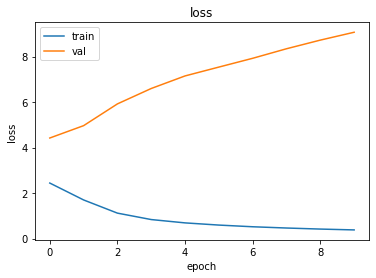

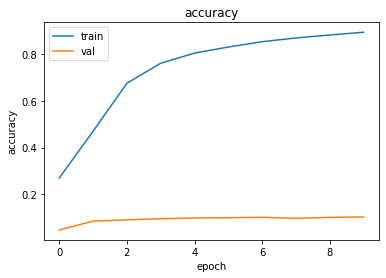

"\nreduced_embedding_tSNE = reduce_tSNE(embedding_matrix)\nvisualize_embeddings(reduced_embedding_tSNE)\nvisualize_embeddings(reduced_embedding_tSNE,\n                     ['good', 'love', 'beautiful'],\n                     word_to_idx)\n\nplt.show()\n"

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial

def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()


def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions

training_info = {
    'verbose': 1,
    'epochs': 10,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10)]
}
model = train_model(model=bidirect_model, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)


# t-SNE
'''
reduced_embedding_tSNE = reduce_tSNE(embedding_matrix)
visualize_embeddings(reduced_embedding_tSNE)
visualize_embeddings(reduced_embedding_tSNE,
                     ['good', 'love', 'beautiful'],
                     word_to_idx)

plt.show()
'''

**Task**: given a corpus of documents, predict the POS tag for each word

**Corpus**:
Ignore the numeric value in the third column, use only the words/symbols and its label. 
The corpus is available at:
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Features**: you MUST use GloVe embeddings as the only input features to the model.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.

**I/O structure**: The input data will have three dimensions:
1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

**Baseline**: two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top; the choice of hyper-parameters is yours.

**Architectures**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and adding an additional dense layer; do not mix these variantions.

**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the two best models of your choice (according to the validation set) must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech. DO NOT CONSIDER THE PUNCTUATION CLASSES.

**Metrics**: the metric you must use to evaluate your final model is the F1-macro, WITHOUT considering punctuation/symbols classes; during the training process you can use accuracy because you can't use the F1 metric unless you use a single (gigantic) batch because there is no way to aggregate "partial" F1 scores computed on mini-batches.

**Discussion and Error Analysis** : verify and discuss if the results on the test sets are coherent with those on the validation set; analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: you are asked to deliver the code of your experiments and a small pdf report of about 2 pages; the pdf must begin with the names of the people of your team and a small abstract (4-5 lines) that sums up your findings.

# Out Of Vocabulary (OOV) terms

How to handle words that are not in GloVe vocabulary?
You can handle them as you want (random embedding, placeholder, whatever!), but they must be STATIC embeddings (you cannot train them).

But there is a very important caveat! As usual, the element of the test set must not influence the elements of the other splits!

So, when you compute new embeddings for train+validation, you must forget about test documents.
The motivation is to emulate a real-world scenario, where you select and train a model in the first stage, without knowing nothing about the testing environment.

For implementation convenience, you CAN use a single vocabulary file/matrix/whatever. The principle of the previous point is that the embeddings inside that file/matrix must be generated independently for train and test splits.

Basically in a real-world scenario, this is what would happen:
1. Starting vocabulary V1 (in this assignment, GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
3. Add embeddings to the vocabulary, so to obtain vocabulary V2=V1+OOV1
4. Training of the model(s)
5. Compute embeddings for terms OOV2 of the validation split 
6. Add embeddings to the vocabulary, so to obtain vocabulary V3=V1+OOV1+OOV2
7. Validation of the model(s)
8. Compute embeddings for terms OOV3 of the test split 
9. Add embeddings to the vocabulary, so to obtain vocabulary V4=V1+OOV1+OOV2+OOV3
10. Testing of the final model

In this case, where we already have all the documents, we can simplify the process a bit, but the procedure must remain rigorous.

1. Starting vocabulary V1 (in this assignment, GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
3. Add embeddings to the vocabulary, so to obtain vocabulary V2=V1+OOV1
4. Compute embeddings for terms OOV2 of the validation split 
5. Add embeddings to the vocabulary, so to obtain vocabulary V3=V1+OOV1+OOV2
6. Compute embeddings for terms OOV3 of the test split 
7. Add embeddings to the vocabulary, so to obtain vocabulary V4=V1+OOV1+OOV2
8. Training of the model(s)
9. Validation of the model(s)
10. Testing of the final model

Step 2 and step 6 must be completely independent of each other, for what concerns the method and the documents. But they can rely on the previous vocabulary (V1 for step 2 and V3 for step 6)
THEREFORE if a word is present both in the training set and the test split and not in the starting vocabulary, its embedding is computed in step 2) and it is not considered OOV anymore in step 6).

# Report
The report must not be just a copy and paste of graphs and tables!

The report must not be longer than 2 pages and must contain:
* The names of the member of your team
* A short abstract (4-5 lines) that sum ups everything
* A general description of the task you have addressed and how you have addressed it
* A short description of the models you have used
* Some tables that sum up your findings in validation and test and a discussion of those results
* The most relevant findings of your error analysis

# Evaluation Criterion

The goal of this assignment is not to prove you can find best model ever, but to face a common task, structure it correctly, and follow a correct and rigorous experimental procedure.
In other words, we don't care if you final models are awful as long as you have followed the correct procedure and wrote a decent report.

The score of the assignment will be computed roughly as follows
* 1 point for the general setting of the problem
* 1 point for the handling of OOV terms
* 1 point for the models
* 1 point for train-validation-test procedure
* 2 point for the discussion of the results, error analysis, and report

This distribution of scores is tentative and we may decide to alter it at any moment.
We also reserve the right to assign a small bonus (0.5 points) to any assignment that is particularly worthy. Similarly, in case of grave errors, we may decide to assign an equivalent malus (-0.5 points).

# Contacts

In case of any doubt, question, issue, or help we highly recommend you to check the [course useful material](https://virtuale.unibo.it/pluginfile.php/1036039/mod_resource/content/2/NLP_Course_Useful_Material.pdf) for additional information, and to use the Virtuale forums to discuss with other students.

You can always contact us at the following email addresses. To increase the probability of a prompt response, we reccomend you to write to both the teaching assistants.

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it


# FAQ
* You can use a non-trainable Embedding layer to load the glove embeddings
* You can use any library of your choice to implement the networks. Two options are tensorflow/keras or pythorch. Both these libraries have all the classes you need to implement these simple architectures and there are plenty of tutorials around, where you can learn how to use them.